In [ ]:
# Import libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

import ast
import contractions
from wordcloud import WordCloud
import emoji
import re
import string 
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_pickle('dataset/cleaned_reviews.pkl')
df.head()
df.info()

,Id,Tokens,Sentiment_Numeric,TokenCount,Cleaned_Review
0,111028,"[hard, time, log, uninstalled, app, not, insta...",-1,9,hard time log uninstalled app not install app ...
1,211245,"[get, no, match, like, stead, spending, nearly...",-1,8,get no match like stead spending nearly r
2,9624,"[no, good]",-1,2,no good
3,198692,"[get, ban, no, reason, paid, customer, year, m...",-1,9,get ban no reason paid customer year massive joke
4,27599,"[use, app, appalled, incredible, number, scammer]",-1,6,use app appalled incredible number scammer


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 50000 non-null  int64 
 1   Tokens             50000 non-null  object
 2   Sentiment_Numeric  50000 non-null  int64 
 3   TokenCount         50000 non-null  int64 
 4   Cleaned_Review     50000 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.9+ MB


## Splitting the data into training and test data set

Before running the models, the dataset will be divided into the training (used to train the model) and testing data (on which the model will predict the sentiments and results will be compared with original labels for accuracy or other test metrics). 

It's important to make sure the classes are equally spread, which will lower the chances of having insufficient model trainning with biased results.

In [79]:
from sklearn.model_selection import train_test_split
X = df['Cleaned_Review']
y = df['Sentiment_Numeric']

# X is input features and y is target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# Check the shape of the training and testing sets
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (37500,) (37500,)
Testing data shape: (12500,) (12500,)


<Figure size 600x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x7f2253e2d820>,
 [Text(0.09587131702242369, -1.0958141679009201, 'Training Set'),
  Text(-0.09587131702242355, 1.0958141679009201, 'Test Set')],
 [Text(0.052293445648594734, -0.5977168188550473, '75.0%'),
  Text(-0.05229344564859466, 0.5977168188550473, '25.0%')])

(-1.0999985637022025,
 1.0999945544067784,
 -1.0999993039070184,
 1.0999998115916407)

Text(0.5, 1.0, 'Train & Test Split')

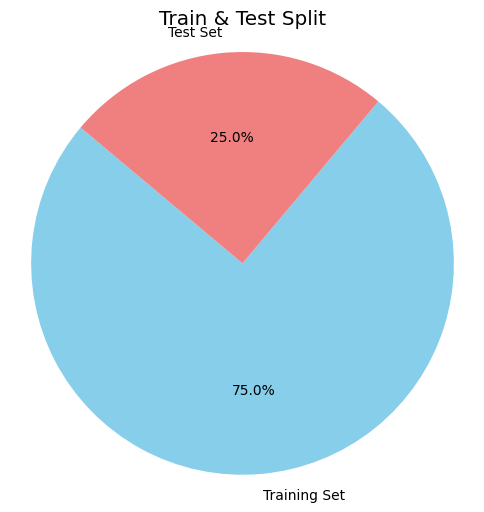

<Axes: xlabel='Sentiment_Numeric'>

Text(0.5, 1.0, 'Sentiment Distribution in Train & Test')

Text(0, 0.5, 'Proportion')

Text(0.5, 0, 'Sentiment')

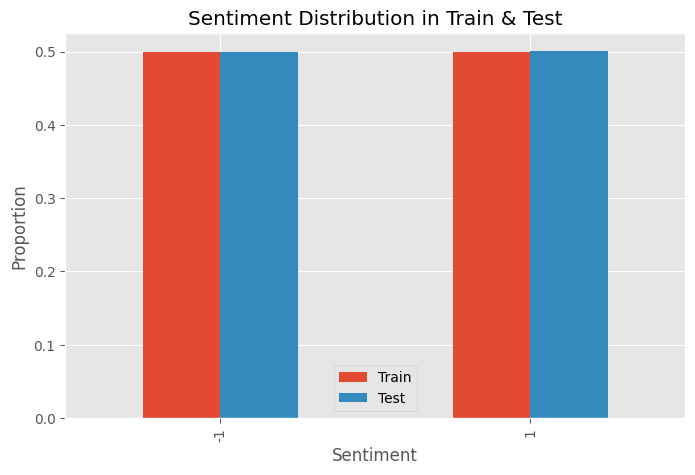

In [104]:
# Train & Test DataSet Distribution 
labels = ['Training Set', 'Test Set']
sizes = [len(X_train), len(X_test)]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=140)
plt.axis('equal')
plt.title('Train & Test Split')
plt.show()

# Sentiment Distribution in Train & Test 
train_distribution = y_train.value_counts(normalize=True).rename('Train').to_frame()
test_distribution = y_test.value_counts(normalize=True).rename('Test').to_frame()
split_distribution = train_distribution.join(test_distribution)
split_distribution.plot(kind='bar', figsize=(8,5))
plt.title('Sentiment Distribution in Train & Test')
plt.ylabel('Proportion')
plt.xlabel('Sentiment')
plt.show()

These visualizations confirm that the train-test split was conducted correctly. The pie chart shows a 75%-25% split. The bar plot indicates that both sets maintain the balanced proportion of positive and negative reviews, which is important for fair model evaluation.

## Model Building

### Vectorization (Feature Engineering)

TF-IDF (Term Frequency-Inverse Document Frequency) was chosen for vectorising review text into numerical features, by balancing word frequency within each review with its rarity across the dataset. 

TF-IDF is especially well-suited for short texts like app reviews, where capturing the importance of individual terms matters more than capturing word order or complex semantic relationships. As shown in Analytics Vidhya, this method has been successfully applied in sentiment analysis tasks with review data, demonstrating its practicality for this project.
https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1 

Even though TF-IDF is a feature extraction step, it is important to first split the dataset into train and test sets before applying vectorisation. This ensures that the vectoriser only learns from the training data and then transforms the test set using the same learned vocabulary and IDF weights. This approach prevents data leakage and ensures the evaluation reflects real-world performance.

In [23]:
# Fit TF-IDF on Training Data and Transform Both Train & Test
tfidf = TfidfVectorizer(max_features = 5000)
# Fit on X_train only
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform X_test with the same vectorizer
X_test_tfidf = tfidf.transform(X_test)

### Logistic Regression

Logistic Regression is used in this project as a baseline classifier for sentiment prediction.Its simplicity and interpretability make it ideal as a baseline, providing a clear point of comparison for evaluating more advanced models.

LogisticRegression(max_iter=1000, random_state=42)

--------------------- Logistic Regression ---------------------
Test Accuracy: 0.8728

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.88      0.87      6245
           1       0.88      0.87      0.87      6255

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.722222222222214, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix - SVM')

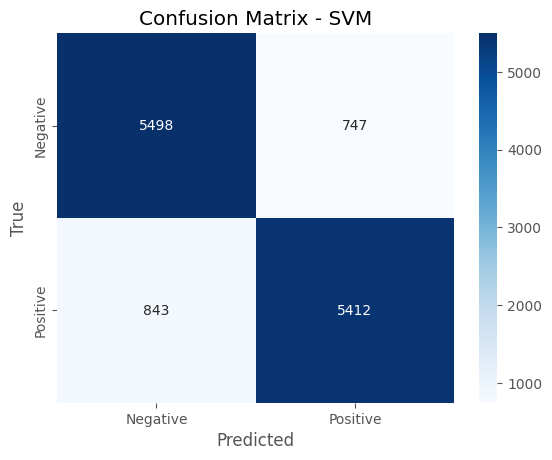

In [24]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate on Test Set
y_pred = model.predict(X_test_tfidf)

print("--------------------- Logistic Regression ---------------------")
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix Plot
class_labels = ['Negative', 'Positive'] 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

Logistic Regression achieved an accuracy of approximately 87%, performing consistently across both sentiment classes. During vectorisation, the max_features parameter in TF-IDF was deliberately reduced from 40,000 to 5,000. This decision was made to reduce computational complexity and avoid overfitting, especially considering the size of the dataset (50,000 reviews) and the relatively short length of individual reviews. While this slight reduction in feature space led to a small drop in accuracy, the overall performance remains solid, demonstrating that much of the important sentiment signal is still captured within the top 5,000 features.

### Support Vector Machine (SVM) Classifier

SVM is also used because it performs well on binary classification tasks with high-dimensional data, such as TF-IDF vectors. As shown in MathWorks, SVMs have been successfully applied to text classification and are known for finding the optimal boundary between classes, making them a reliable choice for sentiment analysis. 

https://www.mathworks.com/help/stats/support-vector-machines-for-binary-classification.html 

SVC()

--------------------- SVM ---------------------
Test Accuracy: 0.87992

Classification Report:
               precision    recall  f1-score   support

          -1       0.87      0.89      0.88      6245
           1       0.89      0.87      0.88      6255

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.722222222222214, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix - SVM')

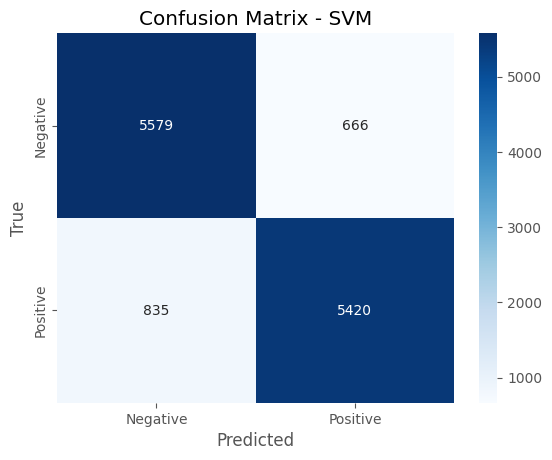

In [25]:
# Train Support Vector Machine (SVM) Classifier
classifier_svm = SVC()
classifier_svm.fit(X_train_tfidf, y_train)

# Predict on Test Set
y_pred_svm = classifier_svm.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Print Results
print("--------------------- SVM ---------------------")
print("Test Accuracy:", accuracy_svm)
print("\nClassification Report:\n", report_svm)

# Confusion Matrix Plot
class_labels = ['Negative', 'Positive']  # Update this if your labels are different
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

The SVM classifier outperformed logistic regression slightly, reaching 87.99% accuracy. This improvement is expected since SVM can handle non-linearly separable data better by leveraging the kernel trick, even though a linear kernel was used here (default). The confusion matrix also shows a balanced performance across both sentiment classes, making SVM a strong candidate for this task.

### Bernoulli Naive Bayes Classifier

Bernoulli Naive Bayes is a suitable choice for this project because it is designed for binary features — making it well-suited for text data that has been transformed using TF-IDF, where each word’s presence or absence matters. As dating app reviews are often short and direct, this simple model can quickly learn patterns like which words appear in positive vs negative reviews. According to scikit-learn’s documentation, BernoulliNB performs well for document classification tasks, especially when working with large, sparse datasets — exactly the kind of data this project deals with.

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html 

BernoulliNB()

--------------------- Bernoulli Naive Bayes ---------------------
Test Accuracy: 0.78512

Classification Report:
               precision    recall  f1-score   support

          -1       0.89      0.65      0.75      6245
           1       0.73      0.92      0.81      6255

    accuracy                           0.79     12500
   macro avg       0.81      0.79      0.78     12500
weighted avg       0.81      0.79      0.78     12500



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.722222222222214, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix - Bernoulli Naive Bayes')

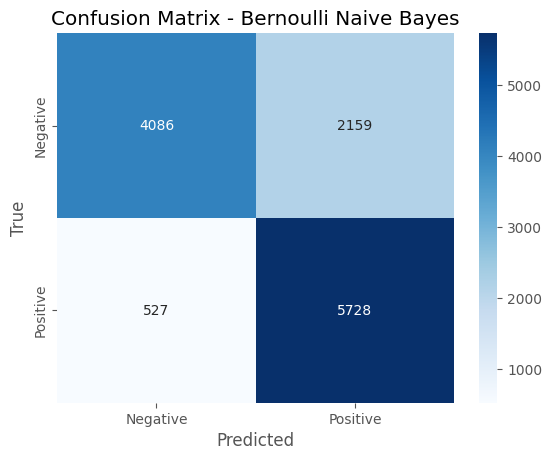

In [11]:
# Train Bernoulli Naive Bayes Classifier
classifier_nb = BernoulliNB()
classifier_nb.fit(X_train_tfidf, y_train)

# Predict on Test Set
y_pred_nb = classifier_nb.predict(X_test_tfidf)

# Evaluation Metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Print Results
print("--------------------- Bernoulli Naive Bayes ---------------------")
print("Test Accuracy:", accuracy_nb)
print("\nClassification Report:\n", report_nb)

# Confusion Matrix Plot
class_labels = ['Negative', 'Positive']  # Update if your labels are different
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Bernoulli Naive Bayes')
plt.show()

Bernoulli Naive Bayes showed the lowest accuracy at 78.5%, especially struggling with negative reviews. This is likely because Naive Bayes assumes feature independence, which is often unrealistic for natural language, where word combinations and context matter. However, its speed and simplicity make it useful as a quick benchmark.

## Feed Forward Neural Network

### Word Embeddings (Feature Engineering)

In this project, the feature extraction method was tailored to suit the nature of each model. For the baseline models — Logistic Regression, Support Vector Machine (SVM), and Bernoulli Naive Bayes — the TF-IDF (Term Frequency-Inverse Document Frequency) technique was used. TF-IDF is widely adopted in traditional text classification tasks because it provides a simple yet effective representation of text data by capturing the importance of terms within individual reviews compared to the entire dataset.

However, for the Feed-Forward Neural Network (FFNN), the feature extraction approach was switched to Word2Vec embeddings. Unlike TF-IDF, which treats words independently, Word2Vec learns dense vector representations that capture semantic meaning based on word co-occurrence patterns. This is particularly suitable for neural networks, which benefit from continuous, lower-dimensional representations that can express word similarity and contextual meaning more effectively than sparse frequency counts.

This hybrid approach — TF-IDF for traditional models and Word2Vec for neural models — was chosen to leverage the strengths of both techniques, ensuring that each model received input features that aligned best with its learning capabilities.

In [82]:
!pip install --upgrade numpy gensim

  Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [83]:
!pip install gensim 

# Downloads a word2vec model pre-trained on 100 billion words from Google News
import gensim.downloader as api

# Load the Word2Vec model
model = api.load('word2vec-google-news-300')

In [84]:
import numpy as np

def review_to_embedding(review, model, embedding_size):
    # Split review into individual words (tokens)
    words = review.split()
    
    # Retrieve embeddings for words that exist in the Word2Vec vocabulary
    vectors = [model[word] for word in words if word in model]
    
    # If no valid words found, return a zero vector
    if len(vectors) == 0:
        return np.zeros(embedding_size)
    
    # Average the embeddings to represent the whole review
    return np.mean(vectors, axis=0)

embedding_size = model.vector_size  

# Convert training and test reviews into vectors using Word2Vec embeddings
X_train_embeddings = np.array([review_to_embedding(review, model, embedding_size) for review in X_train])
X_test_embeddings = np.array([review_to_embedding(review, model, embedding_size) for review in X_test])

In [85]:
# Map labels to 0 and 1 (Negative becomes 0, Positive becomes 1)
y_train_mapped = np.where(y_train == -1, 0, 1)
y_test_mapped = np.where(y_test == -1, 0, 1)

### Initial Version

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 1/30, Train Loss: 0.3688, Train Accuracy: 85.29%, Test Loss: 0.3433, Test Accuracy: 86.21%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 2/30, Train Loss: 0.3336, Train Accuracy: 86.57%, Test Loss: 0.3372, Test Accuracy: 86.63%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 3/30, Train Loss: 0.3222, Train Accuracy: 87.15%, Test Loss: 0.3279, Test Accuracy: 86.88%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 4/30, Train Loss: 0.3157, Train Accuracy: 87.55%, Test Loss: 0.3278, Test Accuracy: 87.05%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 5/30, Train Loss: 0.3100, Train Accuracy: 87.70%, Test Loss: 0.3303, Test Accuracy: 86.71%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 6/30, Train Loss: 0.3050, Train Accuracy: 88.10%, Test Loss: 0.3239, Test Accuracy: 87.06%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 7/30, Train Loss: 0.3002, Train Accuracy: 88.01%, Test Loss: 0.3306, Test Accuracy: 87.11%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 8/30, Train Loss: 0.2965, Train Accuracy: 88.39%, Test Loss: 0.3243, Test Accuracy: 87.20%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 9/30, Train Loss: 0.2914, Train Accuracy: 88.66%, Test Loss: 0.3228, Test Accuracy: 87.20%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 10/30, Train Loss: 0.2885, Train Accuracy: 88.73%, Test Loss: 0.3265, Test Accuracy: 87.26%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 11/30, Train Loss: 0.2844, Train Accuracy: 88.93%, Test Loss: 0.3266, Test Accuracy: 87.23%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 12/30, Train Loss: 0.2802, Train Accuracy: 89.02%, Test Loss: 0.3284, Test Accuracy: 87.19%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 13/30, Train Loss: 0.2764, Train Accuracy: 89.26%, Test Loss: 0.3288, Test Accuracy: 87.25%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 14/30, Train Loss: 0.2727, Train Accuracy: 89.45%, Test Loss: 0.3276, Test Accuracy: 87.28%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 15/30, Train Loss: 0.2698, Train Accuracy: 89.58%, Test Loss: 0.3360, Test Accuracy: 87.14%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 16/30, Train Loss: 0.2675, Train Accuracy: 89.71%, Test Loss: 0.3399, Test Accuracy: 87.07%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 17/30, Train Loss: 0.2637, Train Accuracy: 89.87%, Test Loss: 0.3355, Test Accuracy: 87.23%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 18/30, Train Loss: 0.2596, Train Accuracy: 90.04%, Test Loss: 0.3382, Test Accuracy: 87.14%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 19/30, Train Loss: 0.2573, Train Accuracy: 90.11%, Test Loss: 0.3349, Test Accuracy: 87.08%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 20/30, Train Loss: 0.2536, Train Accuracy: 90.39%, Test Loss: 0.3408, Test Accuracy: 86.95%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 21/30, Train Loss: 0.2502, Train Accuracy: 90.56%, Test Loss: 0.3503, Test Accuracy: 86.50%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 22/30, Train Loss: 0.2484, Train Accuracy: 90.63%, Test Loss: 0.3484, Test Accuracy: 86.91%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 23/30, Train Loss: 0.2452, Train Accuracy: 90.70%, Test Loss: 0.3417, Test Accuracy: 87.02%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 24/30, Train Loss: 0.2417, Train Accuracy: 90.87%, Test Loss: 0.3458, Test Accuracy: 86.96%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 25/30, Train Loss: 0.2397, Train Accuracy: 90.99%, Test Loss: 0.3505, Test Accuracy: 86.90%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 26/30, Train Loss: 0.2366, Train Accuracy: 91.14%, Test Loss: 0.3545, Test Accuracy: 87.27%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 27/30, Train Loss: 0.2337, Train Accuracy: 91.31%, Test Loss: 0.3577, Test Accuracy: 86.95%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 28/30, Train Loss: 0.2334, Train Accuracy: 91.29%, Test Loss: 0.3538, Test Accuracy: 87.20%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 29/30, Train Loss: 0.2280, Train Accuracy: 91.47%, Test Loss: 0.3693, Test Accuracy: 86.75%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 30/30, Train Loss: 0.2276, Train Accuracy: 91.56%, Test Loss: 0.3634, Test Accuracy: 87.06%


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss over Epochs')

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy over Epochs')

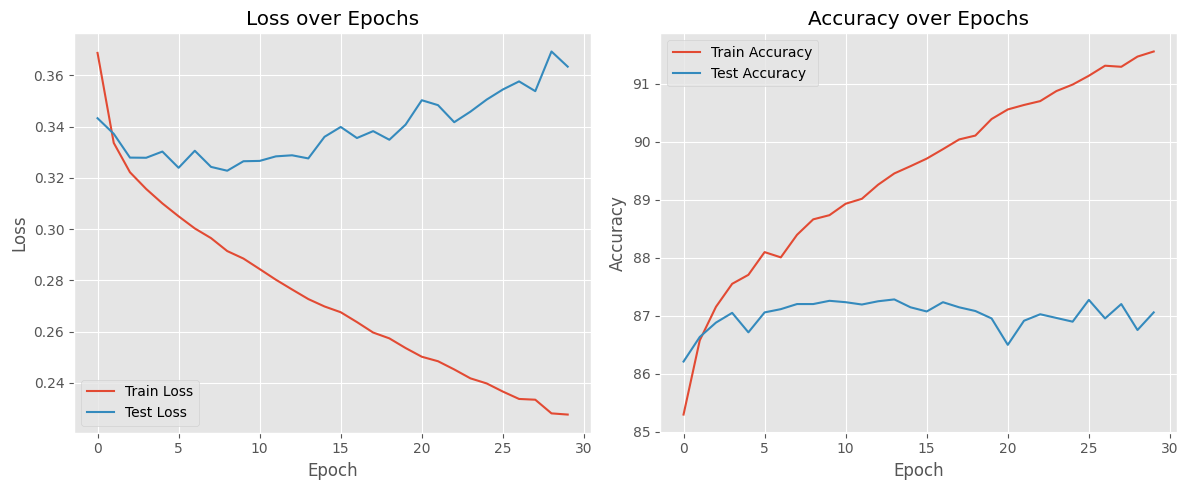

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Define the model
class SentimentFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentFFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Hidden layer to output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model
input_dim = embedding_size  # Dimensionality of the embeddings (e.g., 100 for GloVe)
hidden_dim = 128  # Number of neurons in the hidden layer
output_dim = 2  # Two output classes (0: Negative, 1: Positive)
model = SentimentFFNN(input_dim, hidden_dim, output_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_embeddings, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_embeddings, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    # Calculate training accuracy
    train_accuracy = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted = torch.max(test_outputs.data, 1)
        test_accuracy = 100 * (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy)

    # Print results
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plot the final results
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Show the final plots
plt.tight_layout()
plt.show()

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

--------------------- FFNN Results ---------------------
Test Accuracy: 0.87056

Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.88      0.87      6245
           1       0.88      0.86      0.87      6255

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



<Figure size 600x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted')

Text(45.722222222222214, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix - FFNN')

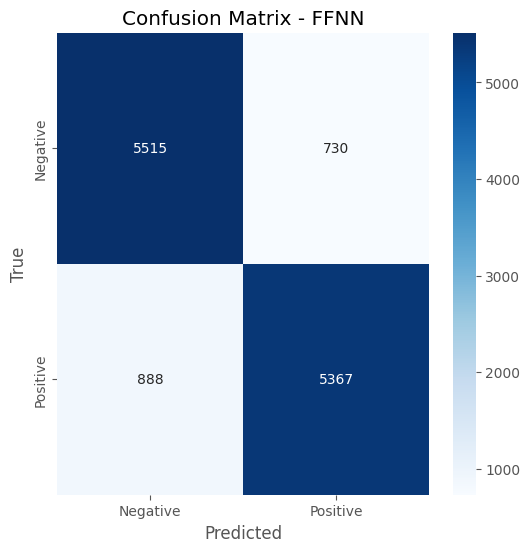

In [100]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, y_pred = torch.max(test_outputs.data, 1)

# Convert predictions back to original labels (-1 and 1)
y_pred_labels = [-1 if label == 0 else 1 for label in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
report = classification_report(y_test, y_pred_labels)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Print results
print("--------------------- FFNN Results ---------------------")
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - FFNN')
plt.show()

### Fine-Tuning 

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 1/20, Train Loss: 0.5076, Train Accuracy: 75.05%, Test Loss: 0.3905, Test Accuracy: 84.56%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 2/20, Train Loss: 0.3768, Train Accuracy: 85.10%, Test Loss: 0.3679, Test Accuracy: 85.20%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 3/20, Train Loss: 0.3625, Train Accuracy: 85.67%, Test Loss: 0.3586, Test Accuracy: 85.75%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 4/20, Train Loss: 0.3540, Train Accuracy: 85.91%, Test Loss: 0.3555, Test Accuracy: 85.48%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 5/20, Train Loss: 0.3478, Train Accuracy: 86.09%, Test Loss: 0.3485, Test Accuracy: 85.94%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 6/20, Train Loss: 0.3429, Train Accuracy: 86.31%, Test Loss: 0.3460, Test Accuracy: 86.13%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 7/20, Train Loss: 0.3388, Train Accuracy: 86.37%, Test Loss: 0.3433, Test Accuracy: 86.05%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 8/20, Train Loss: 0.3356, Train Accuracy: 86.54%, Test Loss: 0.3414, Test Accuracy: 86.09%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 9/20, Train Loss: 0.3329, Train Accuracy: 86.57%, Test Loss: 0.3387, Test Accuracy: 86.32%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 10/20, Train Loss: 0.3306, Train Accuracy: 86.64%, Test Loss: 0.3377, Test Accuracy: 86.30%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 11/20, Train Loss: 0.3283, Train Accuracy: 86.73%, Test Loss: 0.3369, Test Accuracy: 86.28%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 12/20, Train Loss: 0.3263, Train Accuracy: 86.83%, Test Loss: 0.3356, Test Accuracy: 86.30%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 13/20, Train Loss: 0.3247, Train Accuracy: 86.88%, Test Loss: 0.3345, Test Accuracy: 86.52%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 14/20, Train Loss: 0.3232, Train Accuracy: 86.95%, Test Loss: 0.3333, Test Accuracy: 86.57%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 15/20, Train Loss: 0.3217, Train Accuracy: 87.03%, Test Loss: 0.3322, Test Accuracy: 86.54%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 16/20, Train Loss: 0.3204, Train Accuracy: 87.11%, Test Loss: 0.3317, Test Accuracy: 86.48%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 17/20, Train Loss: 0.3189, Train Accuracy: 87.18%, Test Loss: 0.3309, Test Accuracy: 86.50%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 18/20, Train Loss: 0.3174, Train Accuracy: 87.22%, Test Loss: 0.3313, Test Accuracy: 86.65%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 19/20, Train Loss: 0.3165, Train Accuracy: 87.28%, Test Loss: 0.3297, Test Accuracy: 86.68%


SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Epoch 20/20, Train Loss: 0.3150, Train Accuracy: 87.30%, Test Loss: 0.3290, Test Accuracy: 86.70%


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss over Epochs')

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy over Epochs')

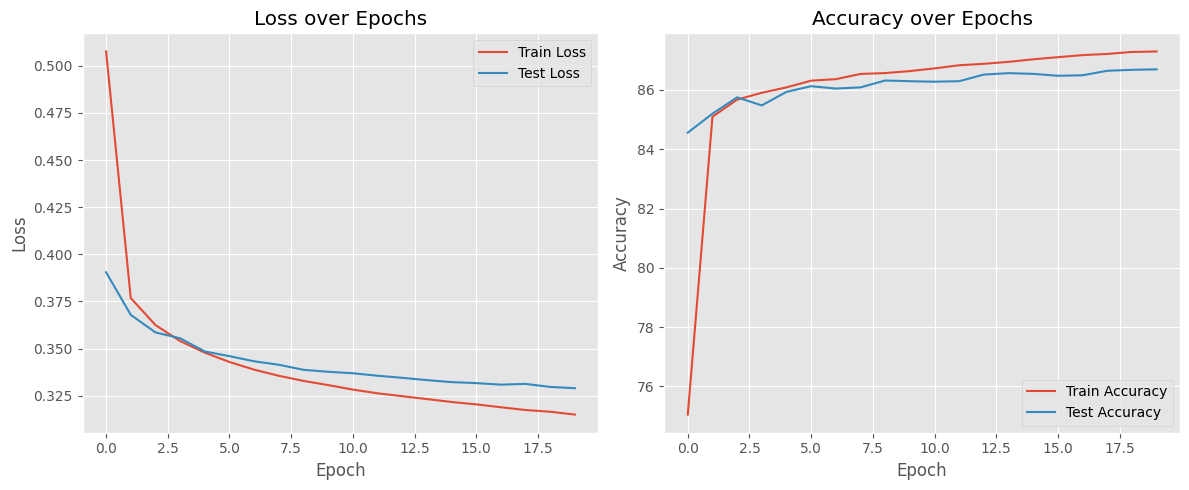

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Define the model
class SentimentFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentFFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout with 50% probability
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = embedding_size  # Dimensionality of the embeddings (e.g., 100 for GloVe)
hidden_dim = 32  # Number of neurons in the hidden layer
output_dim = 2  # Two output classes (0: Negative, 1: Positive)
model = SentimentFFNN(input_dim, hidden_dim, output_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_embeddings, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_embeddings, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    # Calculate training accuracy
    train_accuracy = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted = torch.max(test_outputs.data, 1)
        test_accuracy = 100 * (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy)

    # Print results
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plot the final results
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Show the final plots
plt.tight_layout()
plt.show()

SentimentFFNN(
  (fc1): Linear(in_features=300, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

--------------------- FFNN Results ---------------------
Test Accuracy: 0.86696

Classification Report:
               precision    recall  f1-score   support

          -1       0.85      0.89      0.87      6245
           1       0.88      0.84      0.86      6255

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



<Figure size 600x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted')

Text(45.722222222222214, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix - FFNN')

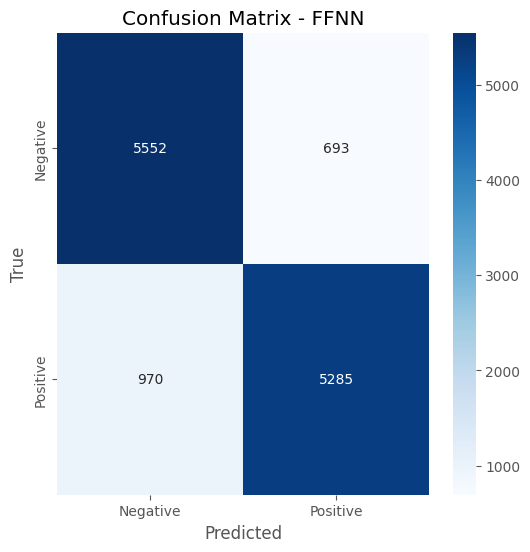

In [102]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, y_pred = torch.max(test_outputs.data, 1)

# Convert predictions back to original labels (-1 and 1)
y_pred_labels = [-1 if label == 0 else 1 for label in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
report = classification_report(y_test, y_pred_labels)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Print results
print("--------------------- FFNN Results ---------------------")
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - FFNN')
plt.show()